In [2]:
print('Hello World!')
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

Hello World!


## Zysk Otwarcia

_Zysk otwarcia_ mierzony jest średnią oceną pozycji zgodnie z silnikiem stockfish po X partii, gdzie X partii to taka liczba, która najlepiej opisuje stan gry po otwarciu. Możliwe jest wykorzystanie kilku momentów partii _X1, X2, X3..._ które mogą opisać sytuację, a następnie sprowadzenie obliczeń do konkretnego wykresu. _X_ -> Ocena pozycji, _Y_ -> Liczba partii z taką pozycją.

## Ryzyko Otwarcia

_Ryzyko Otwarcia_ mierzone jest odchyleniem standardowym lub wariancją wyników danych opisanych powyżej.

## Sharpe Ratio

W teorii portfela Markowitza celem jest znalezienie optymalnego portfela, który maksymalizuje stopę zwrotu przy danym poziomie ryzyka lub minimalizuje ryzyko przy danej stopie zwrotu. Proces ten polega na obliczaniu różnych kombinacji wag aktywów i wybraniu tej, która daje najlepszy stosunek stopa zwrotu / ryzyko (tzw. Sharpe Ratio).

## Efektywna Granica Portfela

https://freedium.cfd/https://towardsdatascience.com/efficient-frontier-in-python-detailed-tutorial-84a304f03e79

Efektywna granica portfela to zbiór portfeli, które oferują najlepszy możliwy stosunek stopy zwrotu do ryzyka. Dla różnych poziomów ryzyka portfel na efektywnej granicy będzie miał najwyższą oczekiwaną stopę zwrotu, a dla różnych poziomów oczekiwanej stopy zwrotu będzie miał najmniejsze możliwe ryzyko.

### Generowanie przykładowych danych dla 2 otwarć

In [53]:
def generate_population(mean: int, std_dev: float, min_val: float, max_val: float, size: int) -> np.array:
    population = np.random.normal(mean, std_dev, size)
    population_clipped = np.clip(population, min_val, max_val)
    return population_clipped


def generate_u_shaped_population(desired_mean: float, min_val: float, max_val: float, size: int) -> np.array:
    # Generate uniform values in the range
    uniform_data = np.random.uniform(min_val, max_val, size)
    
    # Apply parabolic weighting (e.g., y = x^2) to make the distribution U-shaped
    parabolic_data = np.sign(uniform_data) * (np.abs(uniform_data) ** 0.5)
    
    # Scale to fit back into the range if necessary
    parabolic_data = np.clip(parabolic_data, min_val, max_val)
    
    # Compute current mean
    current_mean = np.mean(parabolic_data)
    
    # Shift the data to have the desired mean
    parabolic_data = parabolic_data - current_mean + desired_mean
    
    # Ensure the shifted data is still within the bounds
    parabolic_data = np.clip(parabolic_data, min_val, max_val)
    
    return parabolic_data


In [60]:
o1_mock_population = generate_population(0.2, 0.5, -1.5, 1.5, 1000) # gaussian population (less risky opening)
o2_mock_population = generate_u_shaped_population(-0.1, -1.5, 1.5, 1000) # u-shaped population (more risky opening)

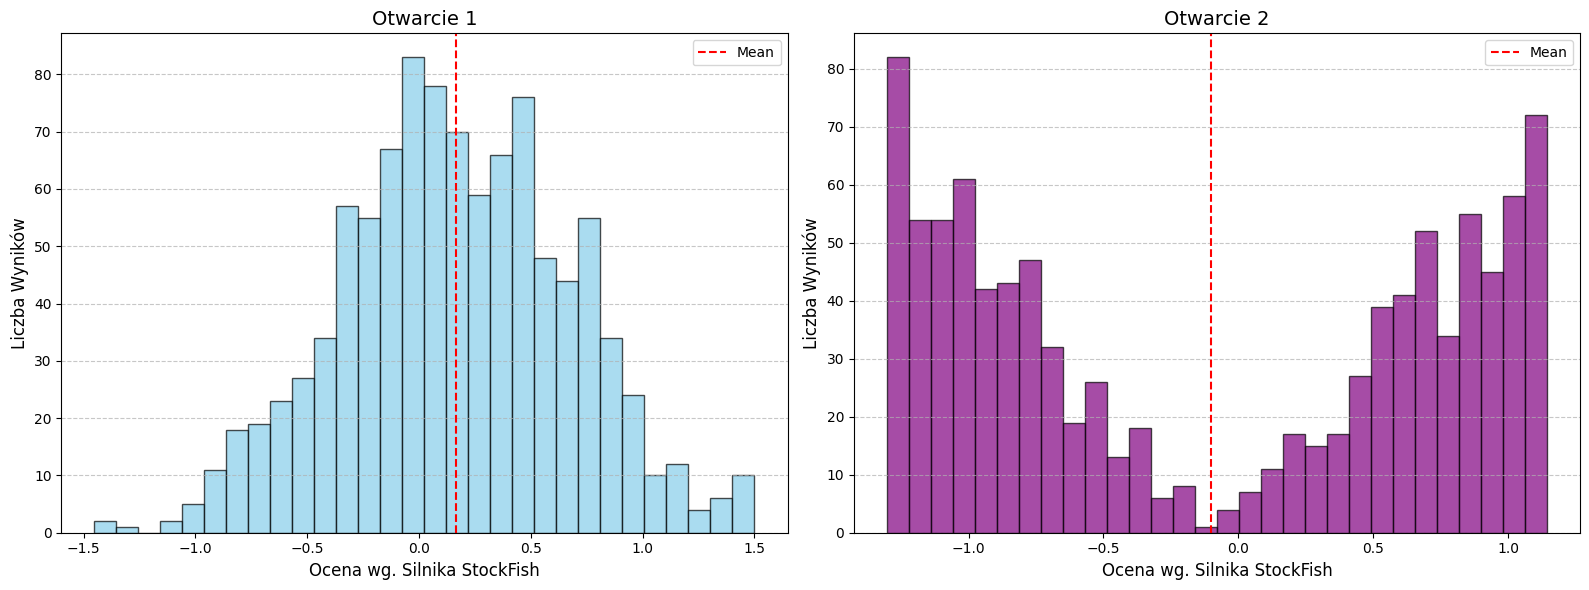

In [77]:
plt.figure(figsize=(16, 6))

# opening 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, second subplot
plt.hist(o1_mock_population, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Otwarcie 1', fontsize=14)
plt.xlabel('Ocena wg. Silnika StockFish', fontsize=12)
plt.ylabel('Liczba Wyników', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=np.mean(o1_mock_population), color='red', linestyle='--', label='Mean')
plt.legend()

# opening 2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
plt.hist(o2_mock_population, bins=30, color='purple', edgecolor='black', alpha=0.7)
plt.title('Otwarcie 2', fontsize=14)
plt.xlabel('Ocena wg. Silnika StockFish', fontsize=12)
plt.ylabel('Liczba Wyników', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(x=np.mean(o2_mock_population), color='red', linestyle='--', label='Mean')
plt.legend()


plt.tight_layout() 
plt.show()

### Obliczanie risk/reward

In [73]:
from typing import Tuple

def calc_risk_and_reward(openings_valuation: np.array) -> Tuple[float, float]: # (std_dev, avg_score)
    risk = np.std(openings_valuation)
    reward = np.mean(openings_valuation)
    return risk, reward

In [74]:
o1_stats = calc_risk_and_reward(o1_mock_population)
ri1, re1 = o1_stats
print(f"Opening stats: \n Risk: {ri1},\n Reward: {re1} ")

Opening stats: 
 Risk: 0.510706006020758,
 Reward: 0.16388155852078143 


In [75]:
o2_stats = calc_risk_and_reward(o2_mock_population)
ri2, re2 = o2_stats
print(f"Opening stats: \n Risk: {ri2},\n Reward: {re2} ")

Opening stats: 
 Risk: 0.8766998204138439,
 Reward: -0.10000000000000002 


### Wykorzystanie Teorii Portfelowej

In [94]:
# since games are completely independent -> correlation = 0
correlation = 0

In [101]:
from scipy.optimize import minimize
from typing import List


# SKIPPING CORRELATION SINCE IT IS = 0 
# https://bookdown.org/compfinezbook/introcompfinr/risk-budgeting-using-portfolio-variance-and-portfolio-standard-deviation.html
def calculate_covariances(risks: List[float]) -> np.ndarray:
    n = len(risks)
    covariance_matrix = np.zeros((n, n))
    for i in range(n):
        covariance_matrix[i, i] = risks[i] ** 2  # Variance of each asset
    return covariance_matrix

def calculate_portfolio_return(weights: np.ndarray, returns: np.ndarray) -> float:
    return np.dot(weights, returns)  # Weighted sum of returns


def calculate_portfolio_risk(weights: np.ndarray, covariance_matrix: np.ndarray) -> float:
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))  # Portfolio risk using covariance matrix


# This would work for continous variables, however for chess game I believe we would need to use something to make some step like 0.1 to ensure that max num of games in portfolio <= 10;
################################################################
## Mixed-Integer Linear Programming (MILP) MIGHT BE SOLUTION! ##
################################################################
def optimize_portfolio(covariance_matrix: np.ndarray, returns: np.ndarray):
    n = len(returns)
    initial_weights = np.ones(n) / n  # Start with equal weights
    bounds = [(0, 1)] * n  
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) 

    # Minimize the portfolio risk (standard deviation) with the given returns and covariance matrix
    result = minimize(lambda w: calculate_portfolio_risk(w, covariance_matrix), initial_weights, bounds=bounds, constraints=constraints)
    
    # Optimal weights
    optimal_weights = result.x
    optimal_risk = calculate_portfolio_risk(optimal_weights, covariance_matrix)
    optimal_return = calculate_portfolio_return(optimal_weights, returns)
    
    return optimal_weights, optimal_risk, optimal_return

In [109]:
risks = [ri1, ri2]  # Example list of risks (standard deviations)
returns = [re1, re2]  # Expected returns for each opening (mean)

covariance_matrix = calculate_covariances(risks)

# Step 2: Optimize the portfolio to minimize risk
optimal_weights, optimal_risk, optimal_return = optimize_portfolio(covariance_matrix, returns)

print("Optimal Weights:", optimal_weights)
print("Optimal Portfolio Risk (Standard Deviation):", optimal_risk)
print("Optimal Portfolio Return:", optimal_return)


Optimal Weights: [0.74610442 0.25389558]
Optimal Portfolio Risk (Standard Deviation): 0.44129116162057785
Optimal Portfolio Return: 0.09688319786727935


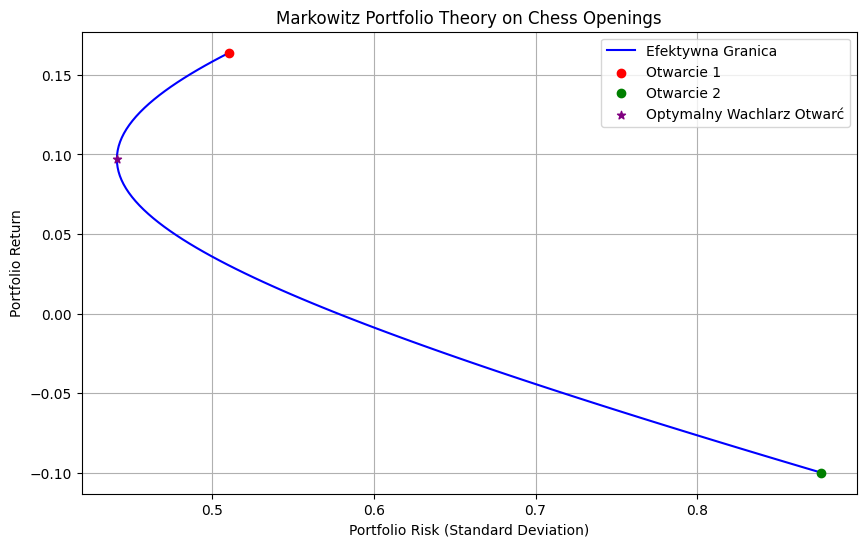

In [110]:

weights_range = np.linspace(0, 1, 100)
portfolio_risks = []
portfolio_returns = []

for w1 in weights_range:
    weights = np.array([w1, 1 - w1])  # Example: using only two openings
    portfolio_risk = calculate_portfolio_risk(weights, covariance_matrix)
    portfolio_return = calculate_portfolio_return(weights, returns)
    portfolio_risks.append(portfolio_risk)
    portfolio_returns.append(portfolio_return)


plt.figure(figsize=(10, 6))

# Plot Efficient Frontier
plt.plot(portfolio_risks, portfolio_returns, label="Efektywna Granica", color='b')

# Plot individual openings (as points)
plt.scatter(risks[0], returns[0], color='red', label='Otwarcie 1', zorder=5)  # Asset 1
plt.scatter(risks[1], returns[1], color='green', label='Otwarcie 2', zorder=5)  # Asset 2

# Plot optimal portfolio (as a point)
plt.scatter(optimal_risk, optimal_return, color='purple', marker='*', label='Optymalny Wachlarz Otwarć', zorder=5)

# Labels and Titles
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.title('Markowitz Portfolio Theory on Chess Openings')
plt.grid(True)
plt.legend()
plt.show()